# Uniform Search Space distribution

A current problem we may encounter is that by looking at the user space as an evenly shaped hypercube, we have an uneven distribution when transforming this into the CLIP-Embedding-Space as clip embeddings are only on a hypersphere. Let's first visualize the current process to demonstrate the weakness in a two dimensional reducion.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

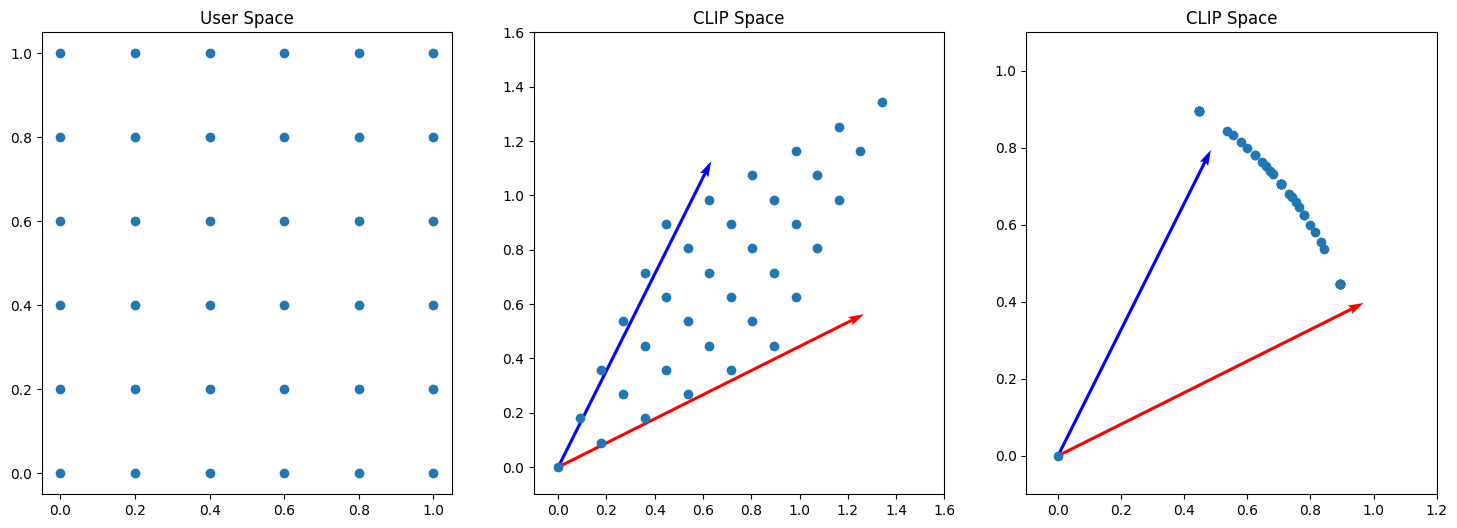

In [25]:
torch.manual_seed(42)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Define two Vectors defining the User Space in the CLIP space
origin = torch.tensor([[0, 0], [0, 0]]) # origin point
heads = torch.tensor([[1., .5], [.5, 1.]])
heads_normed = F.normalize(heads, p=2, dim=-1)

# Generate random samples in the user space
#x_rand = torch.rand(size=(200, 2)).uniform_()

# Generate a mesh grid in the user space
# Parameters
num_points = 6  # Number of points along each axis
x_min, x_max = .0, 1.0  # Range for the x-axis
y_min, y_max = .0, 1.0  # Range for the y-axis

# Generate evenly spaced points along x and y axes
x = torch.linspace(x_min, x_max, num_points)
y = torch.linspace(y_min, y_max, num_points)

# Create a grid of 2D points
x_grid, y_grid = torch.meshgrid(x, y)

# Flatten the grid to get the coordinates
x_rand = torch.stack([x_grid.flatten(), y_grid.flatten()], dim=1)

ax[0].scatter(x_rand[:,0], x_rand[:,1])
ax[0].set_title('User Space')

# Plot random samples transformed into the user space
embeds =  x_rand @ heads_normed

ax[1].quiver(*origin, heads_normed[:,0], heads_normed[:,1], color=['r','b'], scale=1.2)
ax[1].scatter(embeds[:,0], embeds[:,1])
ax[1].set_xlim(-0.1, 1.6)
ax[1].set_ylim(-0.1, 1.6)
ax[1].set_title('CLIP Space')

# Project embeds on the spheres surface
embeds_proj = F.normalize(embeds, p=2, dim=-1)
ax[2].quiver(*origin, heads_normed[:,0], heads_normed[:,1], color=['r','b'], scale=1.2)
ax[2].scatter(embeds_proj[:,0], embeds_proj[:,1])
ax[2].set_xlim(-0.1, 1.2)
ax[2].set_ylim(-0.1, 1.1)
ax[2].set_title('CLIP Space')

plt.show()

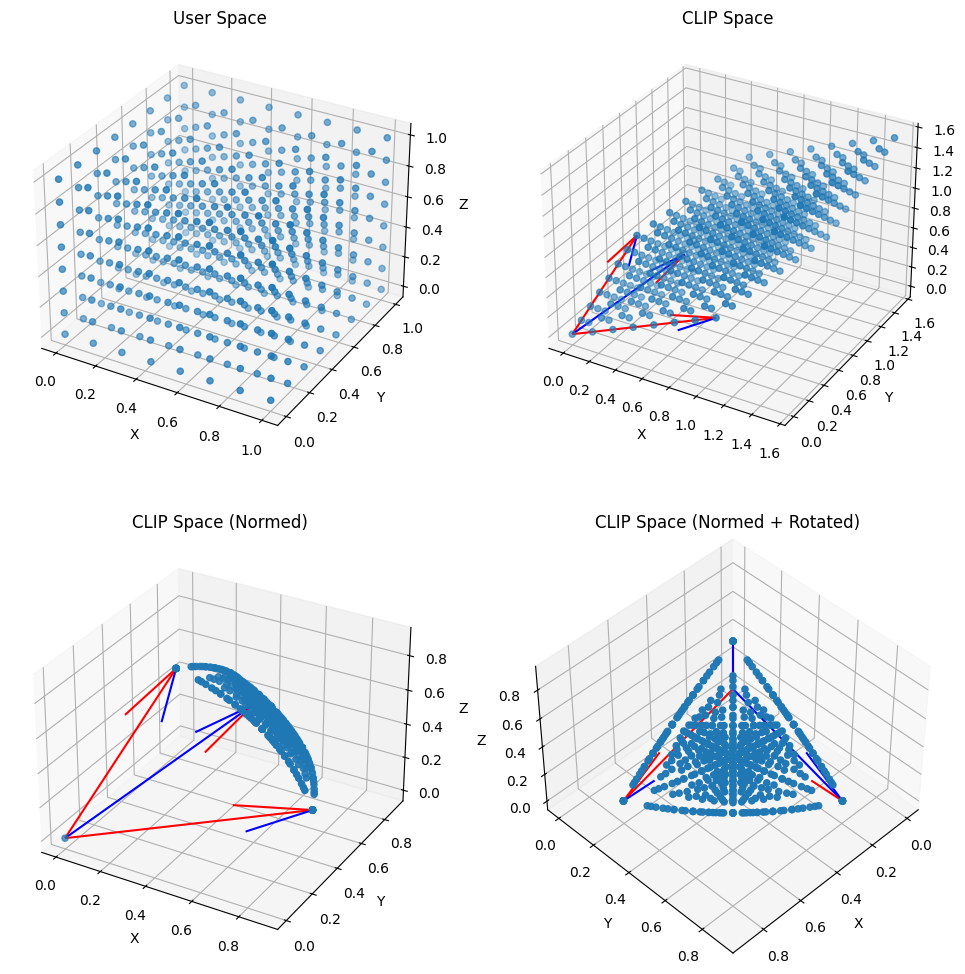

In [23]:
torch.manual_seed(42)

# Define three Vectors defining the User Space in the CLIP space
origin = torch.tensor([[0, 0, 0], [0, 0, 0], [0, 0, 0]]) # origin point
heads = torch.tensor([[0.35, 0.35, 1.], [0.35, 1., 0.35], [1., 0.35, 0.35]])
heads_normed = F.normalize(heads, p=2, dim=-1)

# Generate random samples in the user space
# x_rand = torch.rand(size=(500, 3))

# Generate a mesh grid in the user space
# Parameters
num_points = 8  # Number of points along each axis
x_min, x_max = .0, 1.0  # Range for the x-axis
y_min, y_max = .0, 1.0  # Range for the y-axis
z_min, z_max = .0, 1.0  # Range for the y-axis

# Generate evenly spaced points along x and y axes
x = torch.linspace(x_min, x_max, num_points)
y = torch.linspace(y_min, y_max, num_points)
z = torch.linspace(z_min, z_max, num_points)

# Create a grid of 2D points
x_grid, y_grid, z_grid = torch.meshgrid(x, y, z)

# Flatten the grid to get the coordinates
x_rand = torch.stack([x_grid.flatten(), y_grid.flatten(), z_grid.flatten()], dim=1)

# Plot the samples in the user space
fig = plt.figure(figsize=(12, 12))
ax_0 = fig.add_subplot(2, 2, 1, projection='3d')
ax_0.scatter(x_rand[:,0], x_rand[:,1], x_rand[:, 2])
ax_0.set_title('User Space')
ax_0.set_xlabel('X')
ax_0.set_ylabel('Y')
ax_0.set_zlabel('Z')

# Plot random samples transformed into the CLIP space
embeds =  x_rand @ heads_normed
ax_1 = fig.add_subplot(2, 2, 2, projection='3d')
ax_1.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_1.scatter(embeds[:,0], embeds[:,1], embeds[:,2])
ax_1.set_title('CLIP Space')
ax_1.set_xlabel('X')
ax_1.set_ylabel('Y')
ax_1.set_zlabel('Z')

# Project embeds on the spheres surface in the CLIP Space
embeds_proj = F.normalize(embeds, p=2, dim=-1)
ax_2 = fig.add_subplot(2, 2, 3, projection='3d')
ax_2.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_2.scatter(embeds_proj[:,0], embeds_proj[:,1], embeds_proj[:,2])
ax_2.set_title('CLIP Space (Normed)')
ax_2.set_xlabel('X')
ax_2.set_ylabel('Y')
ax_2.set_zlabel('Z')

# Same PLot but with a front view
ax_3 = fig.add_subplot(2, 2, 4, projection='3d')
ax_3.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_3.scatter(embeds_proj[:,0], embeds_proj[:,1], embeds_proj[:,2])
ax_3.set_title('CLIP Space (Normed + Rotated)')
ax_3.set_xlabel('X')
ax_3.set_ylabel('Y')
ax_3.set_zlabel('Z')

#Rotate to se the sphere
angle = 90
angle_norm = (angle + 180) % 360 - 180
elev = 45
azim = 45
roll = 0
ax_3.view_init(elev, azim, roll)

plt.show()

# Uneven Distribution

From the Plots above we can clearly analyze that the samples are not uniformly distributed on the sphere's surface. Therefore we need to fix this to allow for a correct search through this space. However, we cannot just simply sample evenly distributed on this sphere but need to find a way to sample in the User Space to allow for this. Lets test some stuff!

First Idea:
When the chosen Vectors are normed to unit length and we only select samples in the user space that sum up to 1, the respective sample should again be of unit length! So only select samples in the user space that sum up to one!
Smartest way to do this? -> There are some problems considering boundaries. In general, after selecting x and y, we can calculate z via z = 1-(x+y) But if z should be in [0, 1] but (x+y) > 1, we have a problem.
Following idea: First we sample x randomly in [0, 1]. Then we randomly sample y in [0, 1-x] and then we calculate z via the above equation.

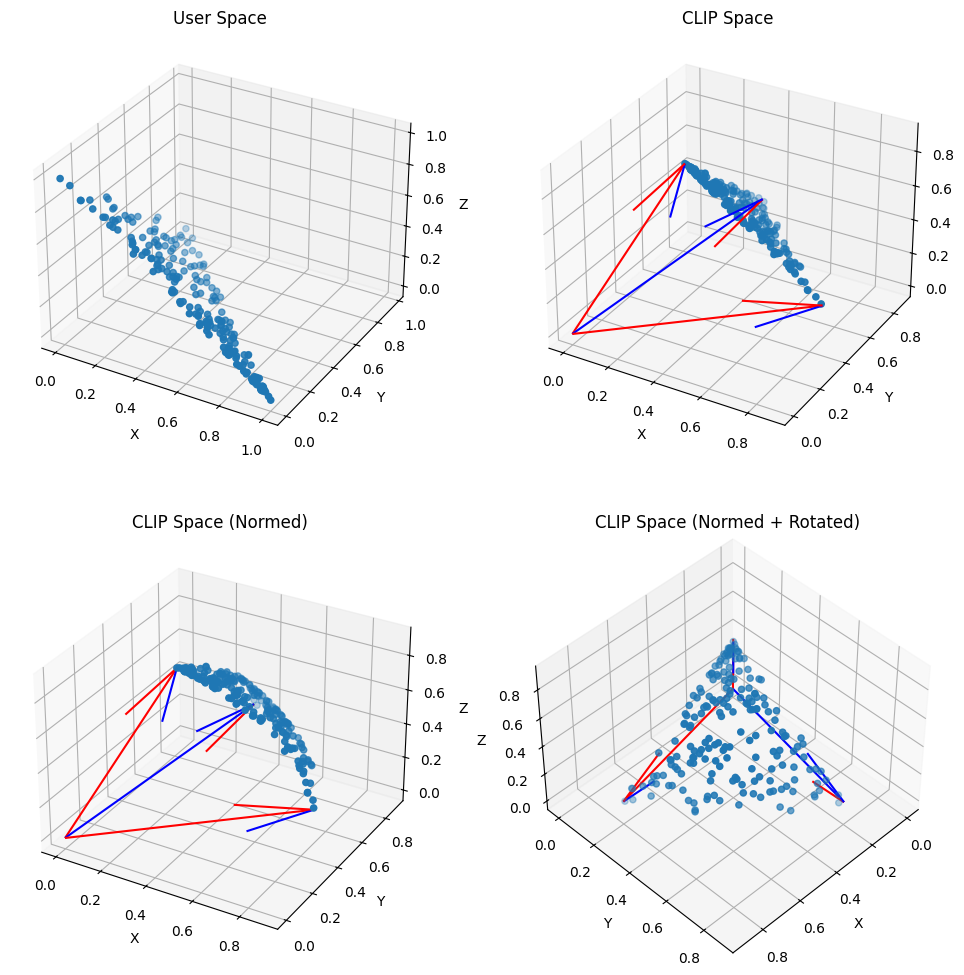

In [42]:
torch.manual_seed(42)

# Define three Vectors defining the User Space in the CLIP space
origin = torch.tensor([[0, 0, 0], [0, 0, 0], [0, 0, 0]]) # origin point
heads = torch.tensor([[0.35, 0.35, 1.], [0.35, 1., 0.35], [1., 0.35, 0.35]])
heads_normed = F.normalize(heads, p=2, dim=-1)

# Generate random samples in the user space
n_samples = 300
x_rand = torch.rand(size=(200, 1))
y_rand = torch.rand(size=(200, 1)) * (1-x_rand)
z_rand = 1 - (x_rand + y_rand)
x_rand = torch.cat((x_rand, y_rand, z_rand), dim=1)


# Plot the samples in the user space
fig = plt.figure(figsize=(12, 12))
ax_0 = fig.add_subplot(2, 2, 1, projection='3d')
ax_0.scatter(x_rand[:,0], x_rand[:,1], x_rand[:, 2])
ax_0.set_title('User Space')
ax_0.set_xlabel('X')
ax_0.set_ylabel('Y')
ax_0.set_zlabel('Z')

# Plot random samples transformed into the CLIP space
embeds =  x_rand @ heads_normed
ax_1 = fig.add_subplot(2, 2, 2, projection='3d')
ax_1.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_1.scatter(embeds[:,0], embeds[:,1], embeds[:,2])
ax_1.set_title('CLIP Space')
ax_1.set_xlabel('X')
ax_1.set_ylabel('Y')
ax_1.set_zlabel('Z')

# Project embeds on the spheres surface in the CLIP Space
embeds_proj = F.normalize(embeds, p=2, dim=-1)
ax_2 = fig.add_subplot(2, 2, 3, projection='3d')
ax_2.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_2.scatter(embeds_proj[:,0], embeds_proj[:,1], embeds_proj[:,2])
ax_2.set_title('CLIP Space (Normed)')
ax_2.set_xlabel('X')
ax_2.set_ylabel('Y')
ax_2.set_zlabel('Z')

# Same PLot but with a front view
ax_3 = fig.add_subplot(2, 2, 4, projection='3d')
ax_3.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_3.scatter(embeds_proj[:,0], embeds_proj[:,1], embeds_proj[:,2])
ax_3.set_title('CLIP Space (Normed + Rotated)')
ax_3.set_xlabel('X')
ax_3.set_ylabel('Y')
ax_3.set_zlabel('Z')

#Rotate to se the sphere
angle = 90
angle_norm = (angle + 180) % 360 - 180
elev = 45
azim = 45
roll = 0
ax_3.view_init(elev, azim, roll)

plt.show()

# Second Idea
Mesh Grid but only the ones that sum up to 1

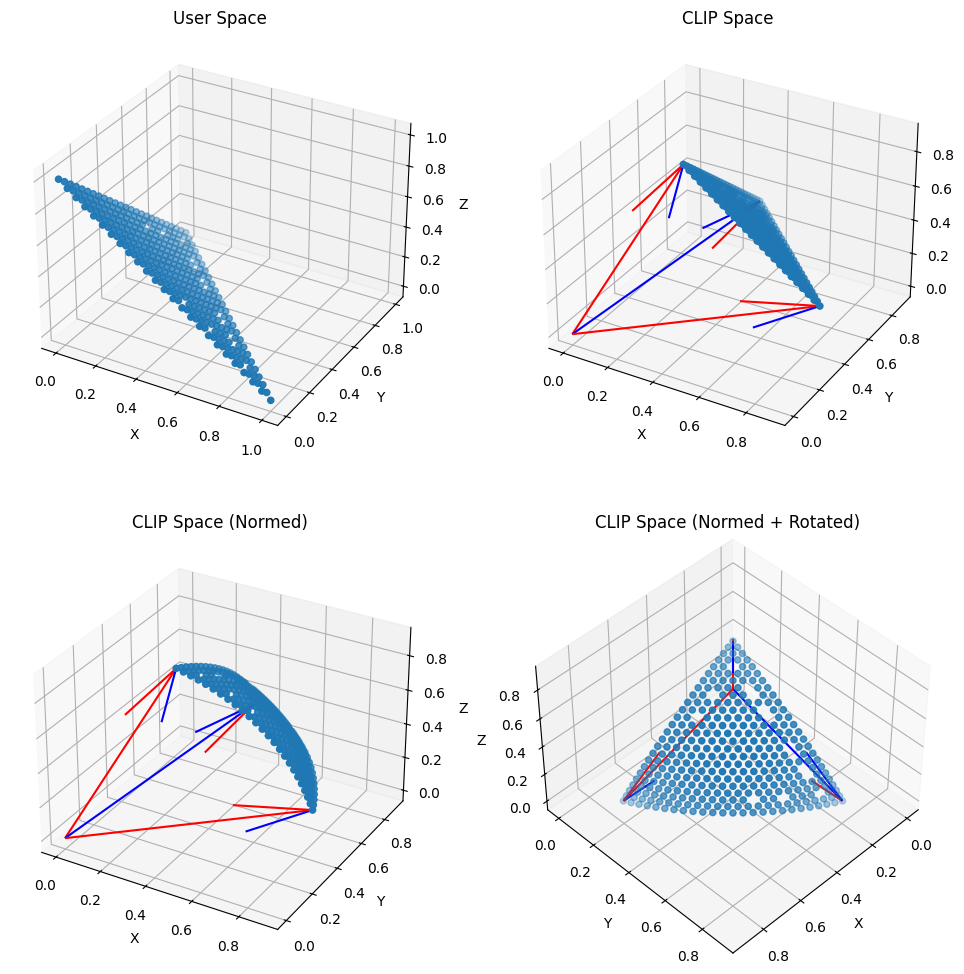

In [53]:
torch.manual_seed(42)

# Define three Vectors defining the User Space in the CLIP space
origin = torch.tensor([[0, 0, 0], [0, 0, 0], [0, 0, 0]]) # origin point
heads = torch.tensor([[0.35, 0.35, 1.], [0.35, 1., 0.35], [1., 0.35, 0.35]])
heads_normed = F.normalize(heads, p=2, dim=-1)

# Generate random samples in the user space
# x_rand = torch.rand(size=(500, 3))

# Generate a mesh grid in the user space
# Parameters
num_points = 25  # Number of points along each axis
x_min, x_max = .0, 1.0  # Range for the x-axis
y_min, y_max = .0, 1.0  # Range for the y-axis
z_min, z_max = .0, 1.0  # Range for the y-axis

# Generate evenly spaced points along x and y axes
x = torch.linspace(x_min, x_max, num_points)
y = torch.linspace(y_min, y_max, num_points)
z = torch.linspace(z_min, z_max, num_points)

# Create a grid of 2D points
x_grid, y_grid, z_grid = torch.meshgrid(x, y, z)

# Flatten the grid to get the coordinates
x_rand = torch.stack([x_grid.flatten(), y_grid.flatten(), z_grid.flatten()], dim=1)

# Filter Datapoints that have a sum lower 1.5
x_rand = x_rand[x_rand.sum(dim=1) == 1.]

# Plot the samples in the user space
fig = plt.figure(figsize=(12, 12))
ax_0 = fig.add_subplot(2, 2, 1, projection='3d')
ax_0.scatter(x_rand[:,0], x_rand[:,1], x_rand[:, 2])
ax_0.set_title('User Space')
ax_0.set_xlabel('X')
ax_0.set_ylabel('Y')
ax_0.set_zlabel('Z')

# Plot random samples transformed into the CLIP space
embeds =  x_rand @ heads_normed
ax_1 = fig.add_subplot(2, 2, 2, projection='3d')
ax_1.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_1.scatter(embeds[:,0], embeds[:,1], embeds[:,2])
ax_1.set_title('CLIP Space')
ax_1.set_xlabel('X')
ax_1.set_ylabel('Y')
ax_1.set_zlabel('Z')

# Project embeds on the spheres surface in the CLIP Space
embeds_proj = F.normalize(embeds, p=2, dim=-1)
ax_2 = fig.add_subplot(2, 2, 3, projection='3d')
ax_2.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_2.scatter(embeds_proj[:,0], embeds_proj[:,1], embeds_proj[:,2])
ax_2.set_title('CLIP Space (Normed)')
ax_2.set_xlabel('X')
ax_2.set_ylabel('Y')
ax_2.set_zlabel('Z')

# Same PLot but with a front view
ax_3 = fig.add_subplot(2, 2, 4, projection='3d')
ax_3.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_3.scatter(embeds_proj[:,0], embeds_proj[:,1], embeds_proj[:,2])
ax_3.set_title('CLIP Space (Normed + Rotated)')
ax_3.set_xlabel('X')
ax_3.set_ylabel('Y')
ax_3.set_zlabel('Z')

#Rotate to se the sphere
angle = 90
angle_norm = (angle + 180) % 360 - 180
elev = 45
azim = 45
roll = 0
ax_3.view_init(elev, azim, roll)

plt.show()

# Third Idea

Sample vectors with length 1 that are uniformly spaced 

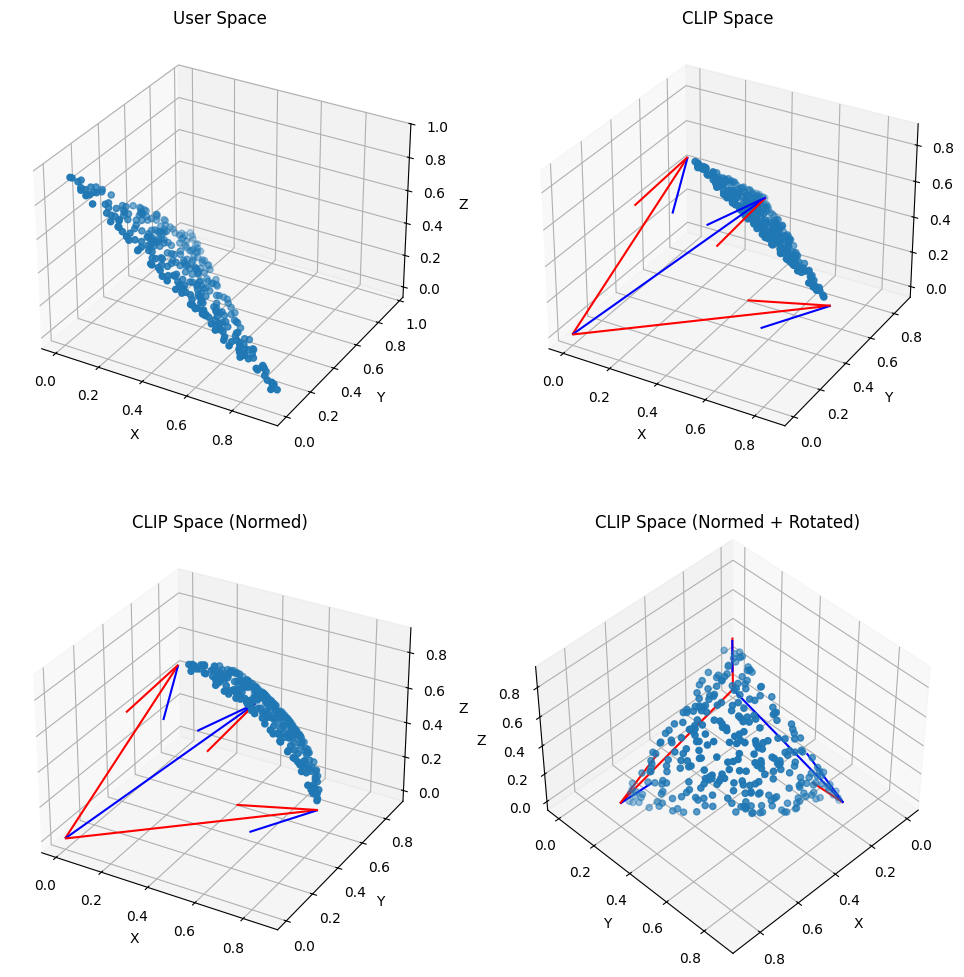

In [55]:
torch.manual_seed(42)

# Define three Vectors defining the User Space in the CLIP space
origin = torch.tensor([[0, 0, 0], [0, 0, 0], [0, 0, 0]]) # origin point
heads = torch.tensor([[0.35, 0.35, 1.], [0.35, 1., 0.35], [1., 0.35, 0.35]])
heads_normed = F.normalize(heads, p=2, dim=-1)

# Generate samples from the Dirichlet distribution
num_samples = 300
alpha = torch.ones(3)  # Concentration parameter (uniform)
distribution = torch.distributions.dirichlet.Dirichlet(alpha)
x_rand = distribution.sample(sample_shape=(num_samples,))

# Plot the samples in the user space
fig = plt.figure(figsize=(12, 12))
ax_0 = fig.add_subplot(2, 2, 1, projection='3d')
ax_0.scatter(x_rand[:,0], x_rand[:,1], x_rand[:, 2])
ax_0.set_title('User Space')
ax_0.set_xlabel('X')
ax_0.set_ylabel('Y')
ax_0.set_zlabel('Z')

# Plot random samples transformed into the CLIP space
embeds =  x_rand @ heads_normed
ax_1 = fig.add_subplot(2, 2, 2, projection='3d')
ax_1.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_1.scatter(embeds[:,0], embeds[:,1], embeds[:,2])
ax_1.set_title('CLIP Space')
ax_1.set_xlabel('X')
ax_1.set_ylabel('Y')
ax_1.set_zlabel('Z')

# Project embeds on the spheres surface in the CLIP Space
embeds_proj = F.normalize(embeds, p=2, dim=-1)
ax_2 = fig.add_subplot(2, 2, 3, projection='3d')
ax_2.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_2.scatter(embeds_proj[:,0], embeds_proj[:,1], embeds_proj[:,2])
ax_2.set_title('CLIP Space (Normed)')
ax_2.set_xlabel('X')
ax_2.set_ylabel('Y')
ax_2.set_zlabel('Z')

# Same PLot but with a front view
ax_3 = fig.add_subplot(2, 2, 4, projection='3d')
ax_3.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_3.scatter(embeds_proj[:,0], embeds_proj[:,1], embeds_proj[:,2])
ax_3.set_title('CLIP Space (Normed + Rotated)')
ax_3.set_xlabel('X')
ax_3.set_ylabel('Y')
ax_3.set_zlabel('Z')

#Rotate to se the sphere
angle = 90
angle_norm = (angle + 180) % 360 - 180
elev = 45
azim = 45
roll = 0
ax_3.view_init(elev, azim, roll)

plt.show()

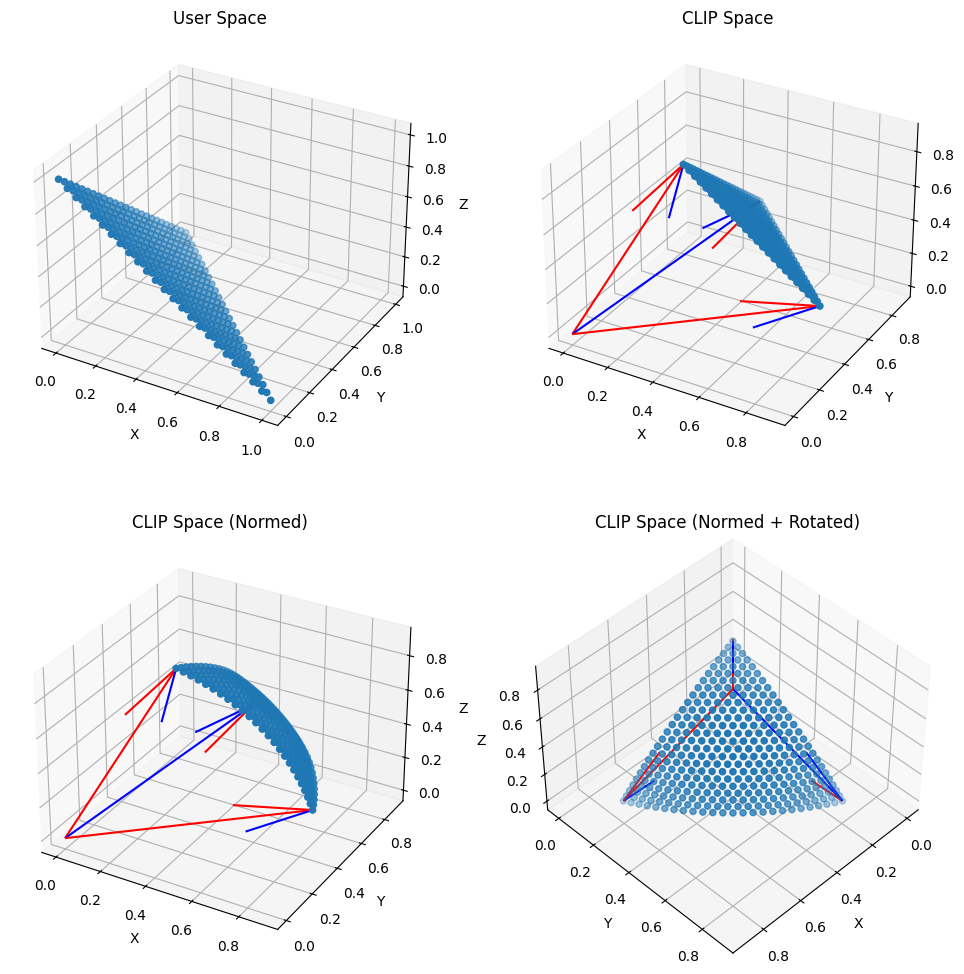

In [64]:
torch.manual_seed(42)

# Define three Vectors defining the User Space in the CLIP space
origin = torch.tensor([[0, 0, 0], [0, 0, 0], [0, 0, 0]]) # origin point
heads = torch.tensor([[0.35, 0.35, 1.], [0.35, 1., 0.35], [1., 0.35, 0.35]])
heads_normed = F.normalize(heads, p=2, dim=-1)

# Parameters
num_samples = 25  # Number of samples along one axis (this will give a resolution)

# Generate 2D grid of points (x, y) in the range [0, 1]
x = torch.linspace(0, 1, num_samples)
y = torch.linspace(0, 1, num_samples)

# Create meshgrid of points
x_grid, y_grid = torch.meshgrid(x, y)

# Mask out the points where x + y > 1 to ensure they lie on the plane x + y + z = 1
mask = (x_grid + y_grid) <= 1

# Get the corresponding z values
z_grid = 1 - x_grid - y_grid

# Apply the mask to filter out points outside the region x + y <= 1
x_grid = x_grid[mask]
y_grid = y_grid[mask]
z_grid = z_grid[mask]

x_rand = torch.cat((x_grid.reshape(-1, 1), y_grid.reshape(-1, 1), z_grid.reshape(-1, 1)), dim=1)

# Plot the samples in the user space
fig = plt.figure(figsize=(12, 12))
ax_0 = fig.add_subplot(2, 2, 1, projection='3d')
ax_0.scatter(x_rand[:,0], x_rand[:,1], x_rand[:, 2])
ax_0.set_title('User Space')
ax_0.set_xlabel('X')
ax_0.set_ylabel('Y')
ax_0.set_zlabel('Z')

# Plot random samples transformed into the CLIP space
embeds =  x_rand @ heads_normed
ax_1 = fig.add_subplot(2, 2, 2, projection='3d')
ax_1.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_1.scatter(embeds[:,0], embeds[:,1], embeds[:,2])
ax_1.set_title('CLIP Space')
ax_1.set_xlabel('X')
ax_1.set_ylabel('Y')
ax_1.set_zlabel('Z')

# Project embeds on the spheres surface in the CLIP Space
embeds_proj = F.normalize(embeds, p=2, dim=-1)
ax_2 = fig.add_subplot(2, 2, 3, projection='3d')
ax_2.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_2.scatter(embeds_proj[:,0], embeds_proj[:,1], embeds_proj[:,2])
ax_2.set_title('CLIP Space (Normed)')
ax_2.set_xlabel('X')
ax_2.set_ylabel('Y')
ax_2.set_zlabel('Z')

# Same PLot but with a front view
ax_3 = fig.add_subplot(2, 2, 4, projection='3d')
ax_3.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_3.scatter(embeds_proj[:,0], embeds_proj[:,1], embeds_proj[:,2])
ax_3.set_title('CLIP Space (Normed + Rotated)')
ax_3.set_xlabel('X')
ax_3.set_ylabel('Y')
ax_3.set_zlabel('Z')

#Rotate to se the sphere
angle = 90
angle_norm = (angle + 180) % 360 - 180
elev = 45
azim = 45
roll = 0
ax_3.view_init(elev, azim, roll)

plt.show()